# Top panel: Decoding accuracy comparison (per bird)

In [99]:
# common
import os
import sys
import json
import pickle as pkl
import numpy as np
import warnings
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from matplotlib.ticker import FuncFormatter

def add_to_sys_path(root_dir):
    for dirpath, dirnames, filenames in os.walk(root_dir):
        sys.path.append(dirpath)        
root_dir = '/home/jovyan/pablo_tostado/bird_song/enSongDec/'
add_to_sys_path(root_dir)

# sklearn
from sklearn.metrics import mean_squared_error

# torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# songbirdcore
import songbirdcore.spikefinder.spike_analysis_helper as sh
import songbirdcore.spikefinder.filtering_helper as fh
import songbirdcore.utils.label_utils as luts
import songbirdcore.utils.plot_utils as puts
import songbirdcore.utils.audio_spectrogram_utils as auts

# EncoDec
from encodec import EncodecModel
from encodec.utils import convert_audio

# Tim S. noise reduce
import noisereduce as nr

# Ensongdec
import ensongdec.utils.audio_utils as au
import ensongdec.utils.signal_utils as su
import ensongdec.utils.encodec_utils as eu
from ensongdec.utils.evaluation_utils import generate_original_and_reconstructed_audio
from ensongdec.evaluation import load_model_statedict
from ensongdec.evaluation_latent_stability import load_model_statedict_align_complimentary_space

## Reconstruct spectrogams and compute reconstruction error

In [6]:
from scipy.stats import ttest_ind

# Function to perform t-tests
def perform_t_tests(df):
    results = []
    groups = df.groupby(['nucleus', 'model'])
    for (nucleus1, model1), group1 in groups:
        for (nucleus2, model2), group2 in groups:
            if (nucleus1, model1) < (nucleus2, model2):  # To avoid duplicate and self-comparisons
                stat, p_value = ttest_ind(group1['Spectrogram reconstruction error'].explode().astype(float),
                                          group2['Spectrogram reconstruction error'].explode().astype(float))
                results.append({
                    'Comparison': f'{nucleus1} {model1} vs. {nucleus2} {model2}',
                    't-statistic': stat,
                    'p-value': p_value
                })
    return pd.DataFrame(results)

spiketrains HVC
Loading model:  z_w12m7_20_RAW_hvc_all_FFNN_20240409_015347.pt
Loading z_w12m7_20_RAW_hvc_all_FFNN_20240409_015347_metadata.json
Loaded model: train_idxs:  [0, 1, 2, 3, 4, 5, 6, 7]  - test_ixs:  [8, 9]  - model_layers:  [228, 64, 64, 128]
Length of neural trials: 700.0 ms, length of audio trials: 700.0 ms. 
Using 2 bins of neural data history.
Data loaders created. Training samples: 808, Testing sample: 206
spiketrains RA
Loading model:  z_w12m7_20_RAW_ra_all_FFNN_20240409_015856.pt
Loading z_w12m7_20_RAW_ra_all_FFNN_20240409_015856_metadata.json
Loaded model: train_idxs:  [0, 1, 2, 3, 4, 5, 6, 7]  - test_ixs:  [8, 9]  - model_layers:  [344, 64, 64, 128]
Length of neural trials: 700.0 ms, length of audio trials: 700.0 ms. 
Using 2 bins of neural data history.
Data loaders created. Training samples: 808, Testing sample: 206
latent-trajectories HVC
Loading model:  z_w12m7_20_TRAJECTORIES_hvc_all_FFNN_20240409_020154.pt
Loading z_w12m7_20_TRAJECTORIES_hvc_all_FFNN_20240409

(Text(0, 0.5, ''), [])

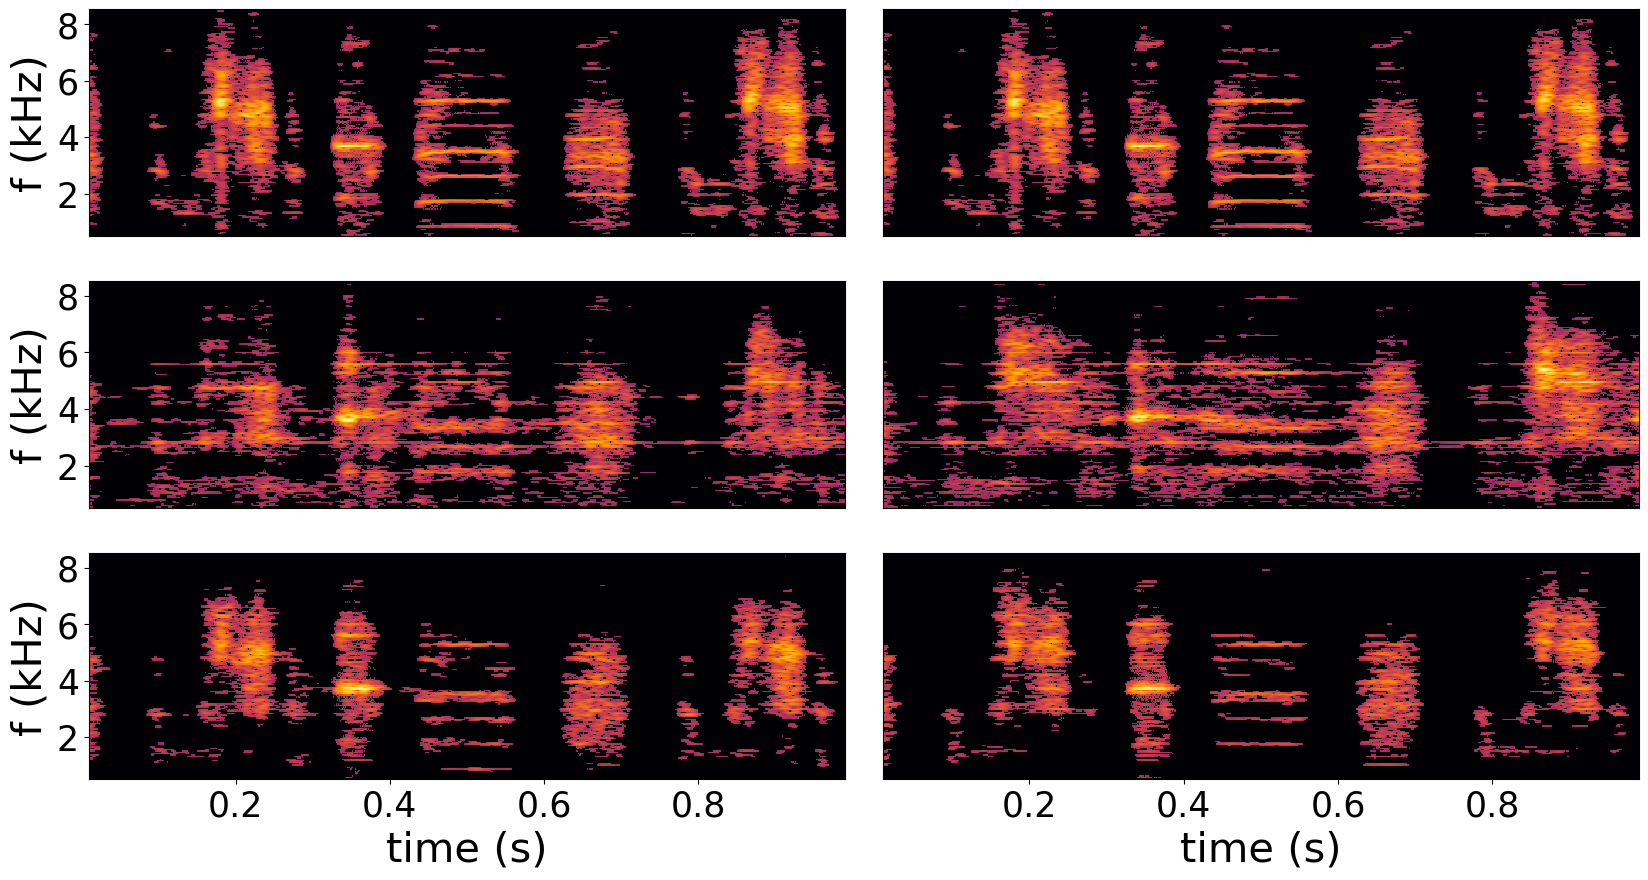

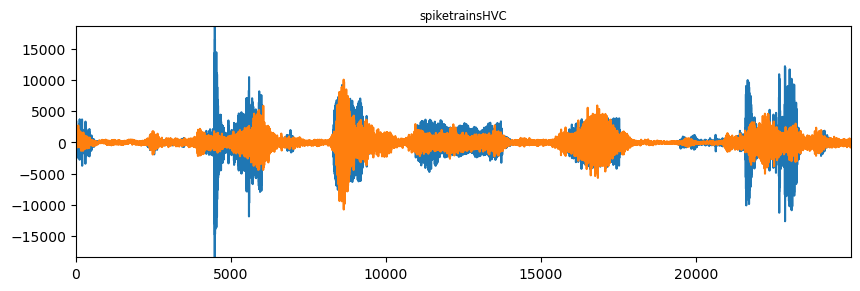

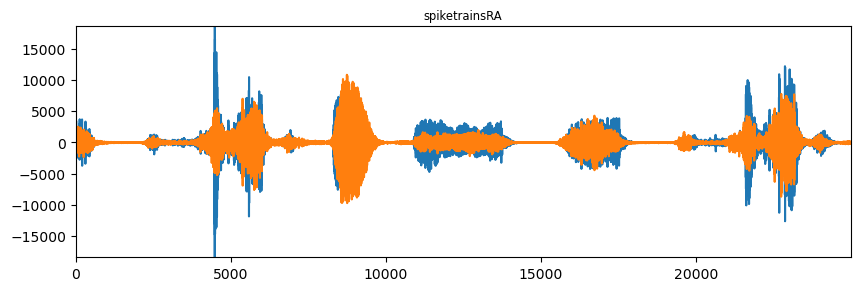

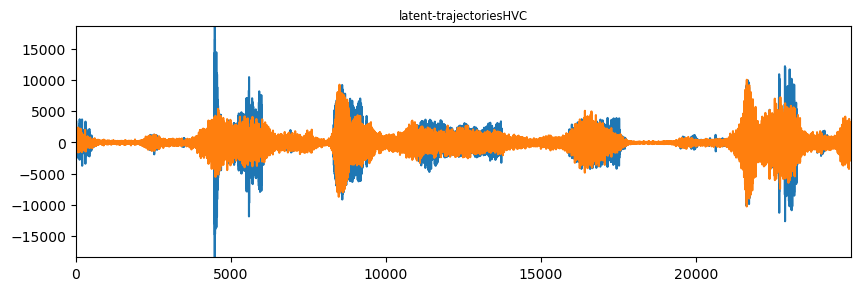

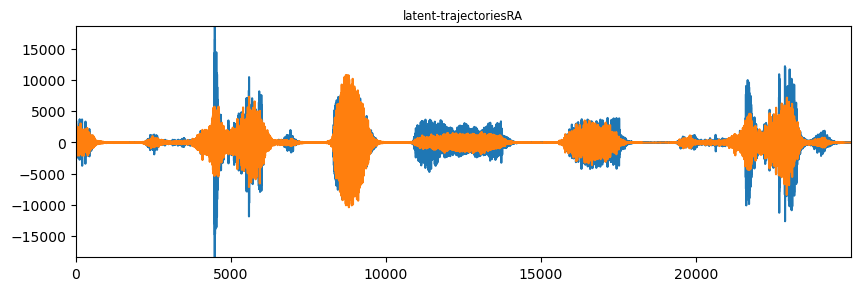

In [2]:
warnings.filterwarnings("ignore")

bird = 'z_w12m7_20'
models_dict = {
    'spiketrains': {
        'HVC': '015347',
        'RA': '015856'
    },
    
    'latent-trajectories': {
        'HVC': '020154',
        'RA': '020155'
    }
}

# Dirs
models_checkpoints_dir = '/home/jovyan/pablo_tostado/bird_song/enSongDec/ensongdec/models_checkpoints/'
dataset_dir = '/home/jovyan/pablo_tostado/bird_song/enSongDec/data/'

column_names = ['model_name', 'nucleus', 'model', 'Spectrogram reconstruction error']
decoding_accuracy_df1 = pd.DataFrame(columns=column_names)

# Plotting setup
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))
plt.subplots_adjust(wspace=0.05)

# Processing each model type and nucleus
for col, model_type in enumerate(models_dict):
    for row, nucleus in enumerate(models_dict[model_type]):
        print(model_type, nucleus)

        # Load model
        model_timestamp = models_dict[model_type][nucleus]
        model_extension = '.pt'  
        model_files = [file for file in os.listdir(models_checkpoints_dir) if file.endswith(model_extension)]
        model_filename = next((file for file in model_files if model_timestamp in file), None)

        print('Loading model: ', model_filename)
        ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scales = load_model_statedict(models_checkpoints_dir, dataset_dir, model_filename, shuffle_inputs=False)

        # Reconstruct spectrogram
        scale = torch.mean(scales)
        original_audio, decoded_audio = generate_original_and_reconstructed_audio(ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scale)

        # Calculate spectrogram reconstruction error
        s1 = su.normalize_signal(au.pretty_spectrogram(original_audio))
        s2 = su.normalize_signal(au.pretty_spectrogram(decoded_audio))
        spec_reconstruction_error = mean_squared_error(s1, s2, multioutput='raw_values')
        
        decoding_accuracy_df1.loc[len(decoding_accuracy_df1)] = [model_filename, nucleus, model_type, spec_reconstruction_error]

        # Plot original and reconstructed
        plot_s = 1
        plot_samples = int(plot_s*fs_audio)
        
        plt.subplots(nrows=1, figsize=(10, 3))
        plt.title(model_type + nucleus)
        plt.plot(original_audio[:plot_samples])
        plt.plot(decoded_audio[:plot_samples])
        
        xlabel = True if row == 1 else False
        au.plot_spectrogram(decoded_audio, fs_audio, plot_samples, ax=axes[row+1, col], xlabel=xlabel)

# Top row: repeat the plot of the original spectrograms in both columns
au.plot_spectrogram(original_audio, fs_audio, plot_samples, ax=axes[0, 0], xlabel=False, ylabel=True)
au.plot_spectrogram(original_audio, fs_audio, plot_samples, ax=axes[0, 1], xlabel=False, ylabel=False)
axes[1,1].set_ylabel(''), axes[1,1].set_yticks([])
axes[2,1].set_ylabel(''), axes[2,1].set_yticks([])



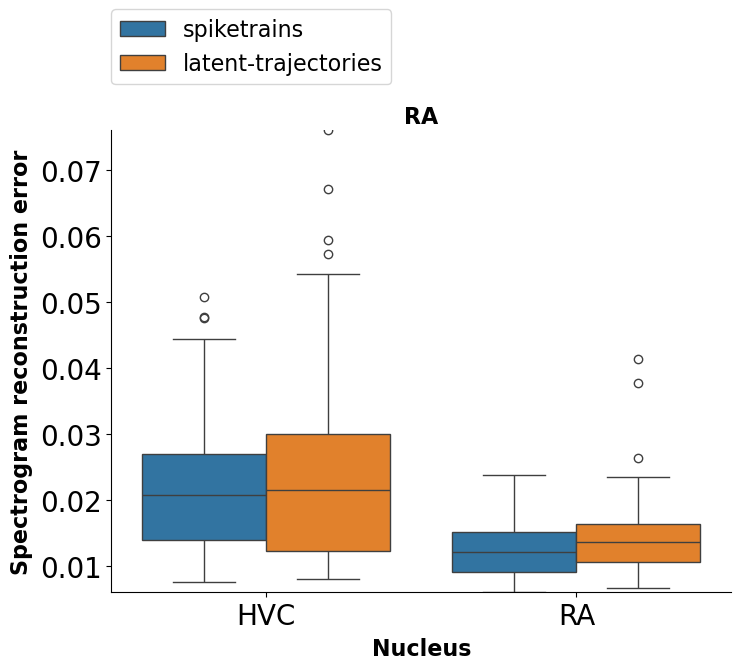

In [3]:
# Create separate rows for each value in the 'error' list
error_type = 'Spectrogram reconstruction error'
df_expanded = decoding_accuracy_df1.explode(error_type)
df_expanded[error_type] = pd.to_numeric(df_expanded[error_type])

# Create a box and whisker plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='nucleus', y=error_type, hue='model', data=df_expanded, notch=False)


plt.title(nucleus, fontsize=16, fontweight='bold')
plt.xlabel('Nucleus', fontsize=16, fontweight='bold')
plt.ylabel(error_type, fontsize=16, fontweight='bold')

# Remove top and right spines
# ax.set_ylim([0, 0.065])
# ax.set_xlim([-0.5, len(significance) - 0.5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=20)  # Adjust 'labelsize' as needed
plt.legend(fontsize='16', loc=(0,1.1)) 

plt.show()

spiketrains HVC
Loading model:  z_r12r13_21_RAW_hvc_all_FFNN_20240409_030450.pt
Loading z_r12r13_21_RAW_hvc_all_FFNN_20240409_030450_metadata.json
Loaded model: train_idxs:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]  - test_ixs:  [37, 38, 39, 40, 41, 42, 43, 44, 45, 46]  - model_layers:  [150, 64, 64, 128]
Length of neural trials: 899.9666666666667 ms, length of audio trials: 899.96 ms. 
Using 3 bins of neural data history.
Data loaders created. Training samples: 4810, Testing sample: 1320
spiketrains RA
Loading model:  z_r12r13_21_RAW_ra_all_FFNN_20240409_031754.pt
Loading z_r12r13_21_RAW_ra_all_FFNN_20240409_031754_metadata.json
Loaded model: train_idxs:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]  - test_ixs:  [37, 38, 39, 40, 41, 42, 43, 44, 45, 46]  - model_layers:  [252, 64, 64, 128]
Length

(Text(0, 0.5, ''), [])

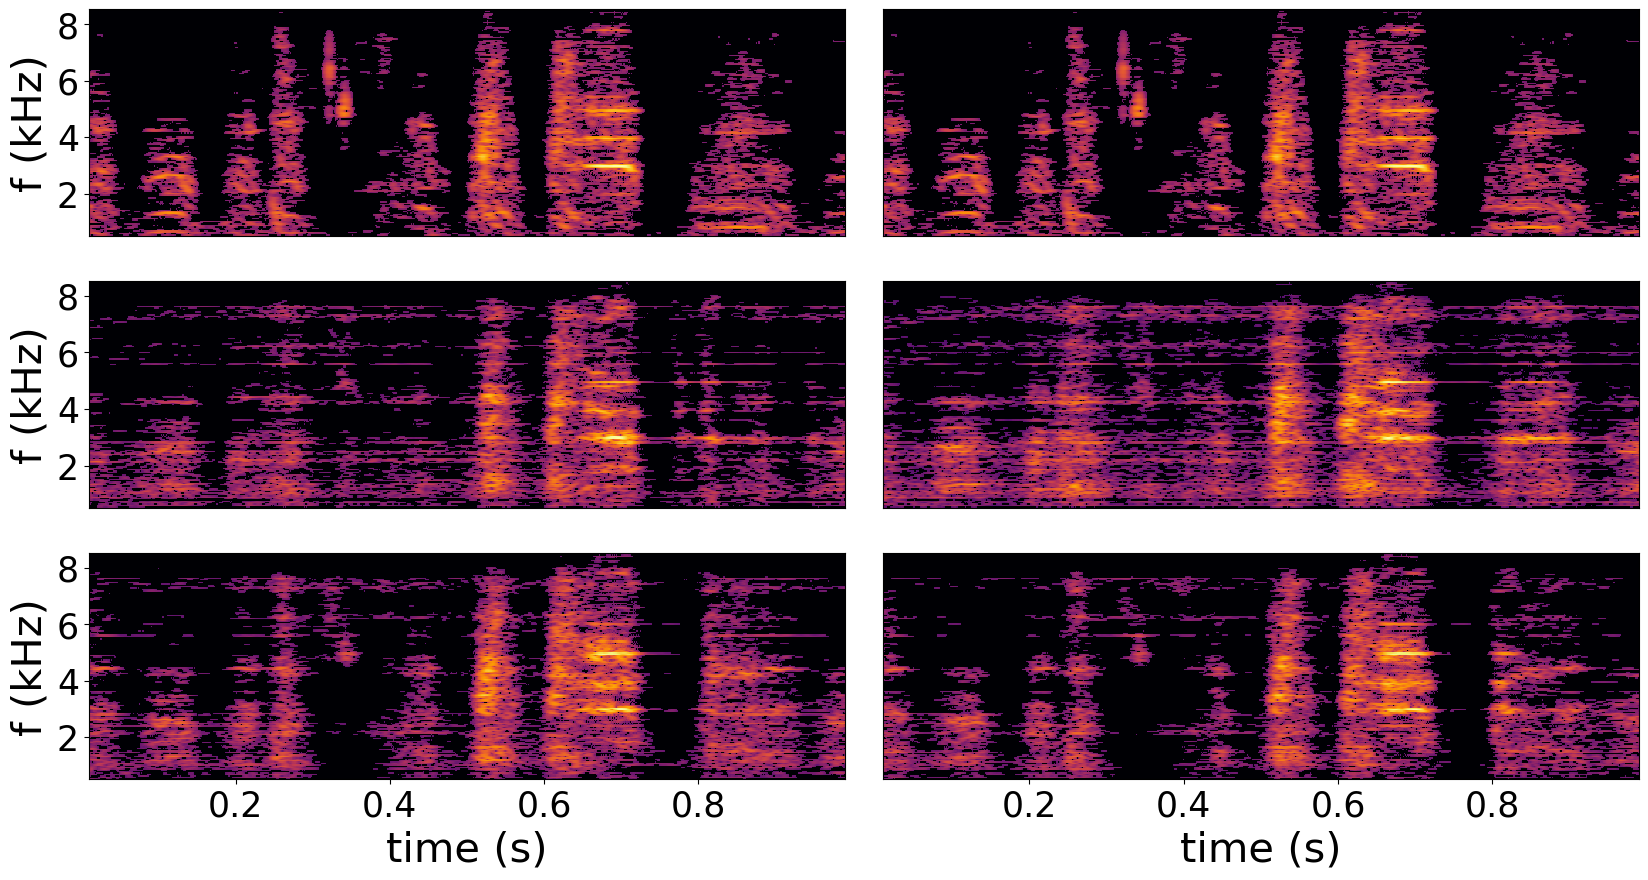

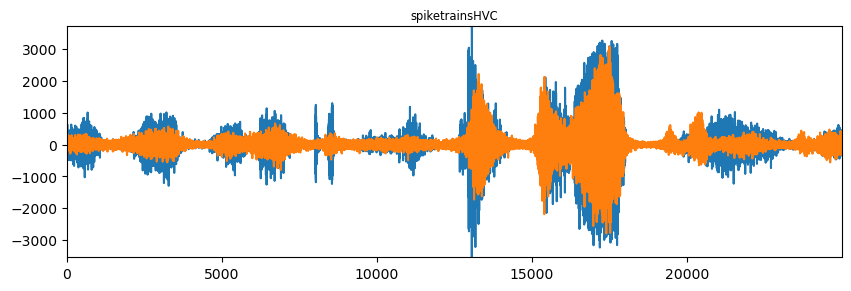

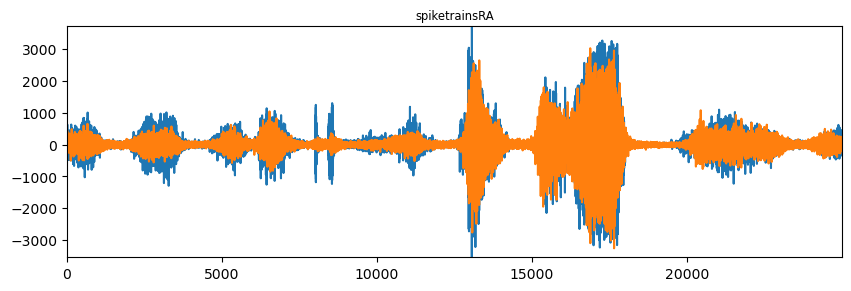

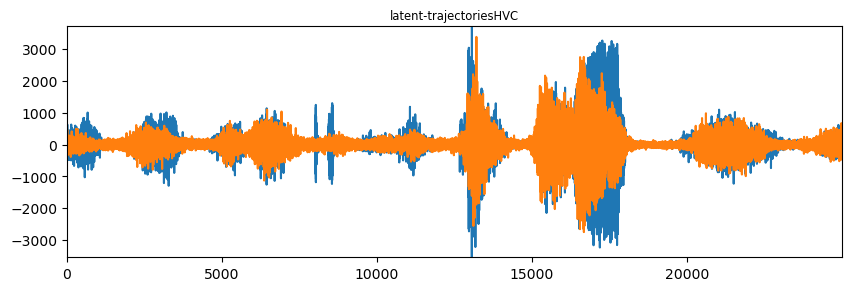

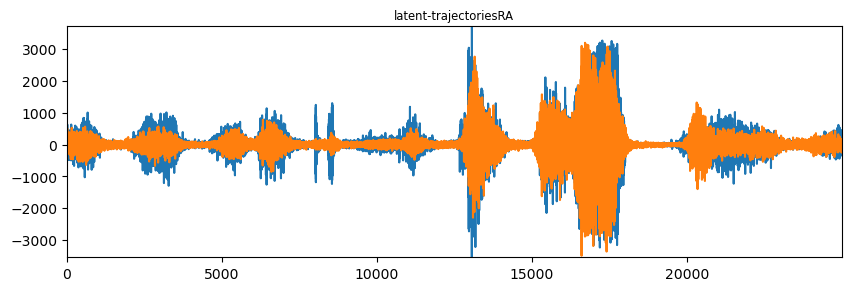

In [4]:
warnings.filterwarnings("ignore")

bird = 'z_r12r13_21'
models_dict = {
    'spiketrains': {
        'HVC': '030450',
        'RA': '031754'
    },
    
    'latent-trajectories': {
        'HVC': '031418',
        'RA': '031507'
    }
}


# Dirs
models_checkpoints_dir = '/home/jovyan/pablo_tostado/bird_song/enSongDec/ensongdec/models_checkpoints/'
dataset_dir = '/home/jovyan/pablo_tostado/bird_song/enSongDec/data/'

column_names = ['model_name', 'nucleus', 'model', 'Spectrogram reconstruction error']
decoding_accuracy_df2 = pd.DataFrame(columns=column_names)

# Plotting setup
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))
plt.subplots_adjust(wspace=0.05)

# Processing each model type and nucleus
for col, model_type in enumerate(models_dict):
    for row, nucleus in enumerate(models_dict[model_type]):
        print(model_type, nucleus)

        # Load model
        model_timestamp = models_dict[model_type][nucleus]
        model_extension = '.pt'  
        model_files = [file for file in os.listdir(models_checkpoints_dir) if file.endswith(model_extension)]
        model_filename = next((file for file in model_files if model_timestamp in file), None)

        print('Loading model: ', model_filename)
        ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scales = load_model_statedict(models_checkpoints_dir, dataset_dir, model_filename, shuffle_inputs=False)

        # Reconstruct spectrogram
        scale = torch.mean(scales)
        original_audio, decoded_audio = generate_original_and_reconstructed_audio(ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scale)

        # Calculate spectrogram reconstruction error
        s1 = su.normalize_signal(au.pretty_spectrogram(original_audio))
        s2 = su.normalize_signal(au.pretty_spectrogram(decoded_audio))
        spec_reconstruction_error = mean_squared_error(s1, s2, multioutput='raw_values')
        
        decoding_accuracy_df2.loc[len(decoding_accuracy_df2)] = [model_filename, nucleus, model_type, spec_reconstruction_error]

        plt.subplots(nrows=1, figsize=(10, 3))
        plt.title(model_type + nucleus)
        plt.plot(original_audio[:plot_samples])
        plt.plot(decoded_audio[:plot_samples])
        
        # Plot original and reconstructed
        plot_ms = 1
        plot_samples = int(plot_ms*fs_audio)
        
        xlabel = True if row == 1 else False
        au.plot_spectrogram(decoded_audio, fs_audio, plot_samples, ax=axes[row+1, col], xlabel=xlabel)

# Top row: repeat the plot of the original spectrograms in both columns
au.plot_spectrogram(original_audio, fs_audio, plot_samples, ax=axes[0, 0], xlabel=False, ylabel=True)
au.plot_spectrogram(original_audio, fs_audio, plot_samples, ax=axes[0, 1], xlabel=False, ylabel=False)
axes[1,1].set_ylabel(''), axes[1,1].set_yticks([])
axes[2,1].set_ylabel(''), axes[2,1].set_yticks([])


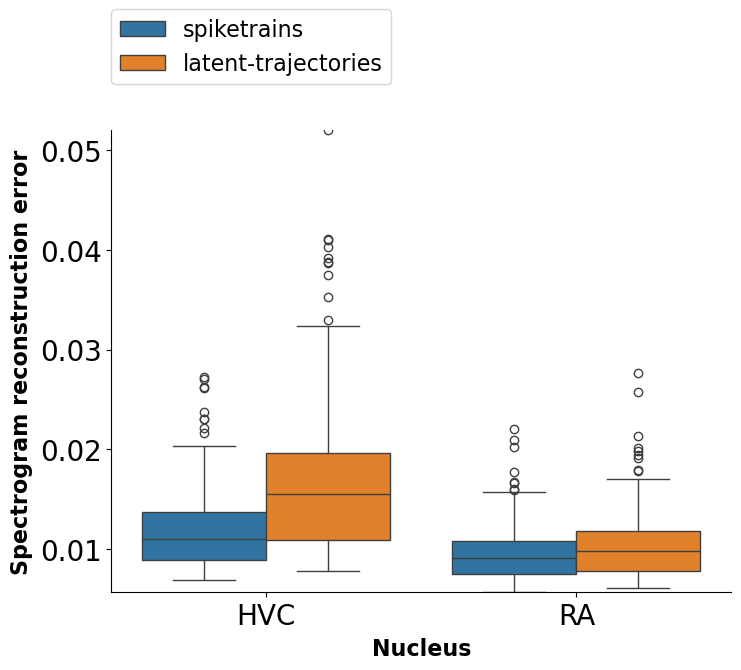

In [28]:
# Create separate rows for each value in the 'error' list
error_type = 'Spectrogram reconstruction error'
df_expanded = decoding_accuracy_df2.explode(error_type)
df_expanded[error_type] = pd.to_numeric(df_expanded[error_type])

# Create a box and whisker plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='nucleus', y=error_type, hue='model', data=df_expanded, notch=False)

plt.xlabel('Nucleus', fontsize=16, fontweight='bold')
plt.ylabel(error_type, fontsize=16, fontweight='bold')

# Remove top and right spines
# ax.set_ylim([0, 0.065])
# ax.set_xlim([-0.5, len(significance) - 0.5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=20)  # Adjust 'labelsize' as needed
plt.legend(fontsize='16', loc=(0,1.1)) 

plt.show()


# Generate figures with shuffle controls

In [109]:
from importlib import reload 
from ensongdec.evaluation import load_model_statedict
import ensongdec.evaluation
reload(ensongdec.evaluation)


<module 'ensongdec.evaluation' from '/home/jovyan/pablo_tostado/bird_song/enSongDec/ensongdec/evaluation.py'>

In [110]:
warnings.filterwarnings("ignore")

bird = 'z_w12m7_20'
models_dict = {
    'spiketrains': {
        'HVC': '015347',
        'RA': '015856'
    },
    
    'latent-trajectories': {
        'HVC': '020154',
        'RA': '020155'
    }
}

# Dirs
models_checkpoints_dir = '/home/jovyan/pablo_tostado/bird_song/enSongDec/ensongdec/models_checkpoints/'
dataset_dir = '/home/jovyan/pablo_tostado/bird_song/enSongDec/data/'

column_names = ['model_name', 'nucleus', 'model', 'Spectrogram reconstruction error']
decoding_accuracy_df3 = pd.DataFrame(columns=column_names)


# Processing each model type and nucleus
for col, model_type in enumerate(models_dict):
    for row, nucleus in enumerate(models_dict[model_type]):
        print(model_type, nucleus)

        # Load model
        model_timestamp = models_dict[model_type][nucleus]
        model_extension = '.pt'  
        model_files = [file for file in os.listdir(models_checkpoints_dir) if file.endswith(model_extension)]
        model_filename = next((file for file in model_files if model_timestamp in file), None)

        for control in ['normal', 'control']:
            print(f'Loading model {model_filename} in {control} mode')
                            
            if control == 'control': 
                ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scales = load_model_statedict(models_checkpoints_dir, dataset_dir, model_filename, shuffle_inputs=True)
            else:
                ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scales = load_model_statedict(models_checkpoints_dir, dataset_dir, model_filename, shuffle_inputs=False)
    
            # Reconstruct spectrogram
            scale = torch.mean(scales)
            original_audio, decoded_audio = generate_original_and_reconstructed_audio(ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scale)
    
            # Calculate spectrogram reconstruction error
            s1 = su.normalize_signal(au.pretty_spectrogram(original_audio))
            s2 = su.normalize_signal(au.pretty_spectrogram(decoded_audio))
            spec_reconstruction_error = mean_squared_error(s1, s2, multioutput='raw_values')
            
            model = model_type+'_shuffle-control' if control == 'control' else model_type
            decoding_accuracy_df3.loc[len(decoding_accuracy_df3)] = [model_filename, nucleus, model, spec_reconstruction_error]


spiketrains HVC
Loading model z_w12m7_20_RAW_hvc_all_FFNN_20240409_015347.pt in normal mode
Loading z_w12m7_20_RAW_hvc_all_FFNN_20240409_015347_metadata.json
Loaded model: train_idxs:  [0, 1, 2, 3, 4, 5, 6, 7]  - test_ixs:  [8, 9]  - model_layers:  [228, 64, 64, 128]
Length of neural trials: 700.0 ms, length of audio trials: 700.0 ms. 
Using 2 bins of neural data history.
Dataset and Dataloader created. Samples: 808
Dataset and Dataloader created. Samples: 206
Train samples:  808 Test samples:  206
Loading model z_w12m7_20_RAW_hvc_all_FFNN_20240409_015347.pt in control mode
Loading z_w12m7_20_RAW_hvc_all_FFNN_20240409_015347_metadata.json
Loaded model: train_idxs:  [0, 1, 2, 3, 4, 5, 6, 7]  - test_ixs:  [8, 9]  - model_layers:  [228, 64, 64, 128]
Length of neural trials: 700.0 ms, length of audio trials: 700.0 ms. 
Using 2 bins of neural data history.
CONTROL: Shuffling model inputs in the test set along the second dimension!
Dataset and Dataloader created. Samples: 808
Dataset and Dat

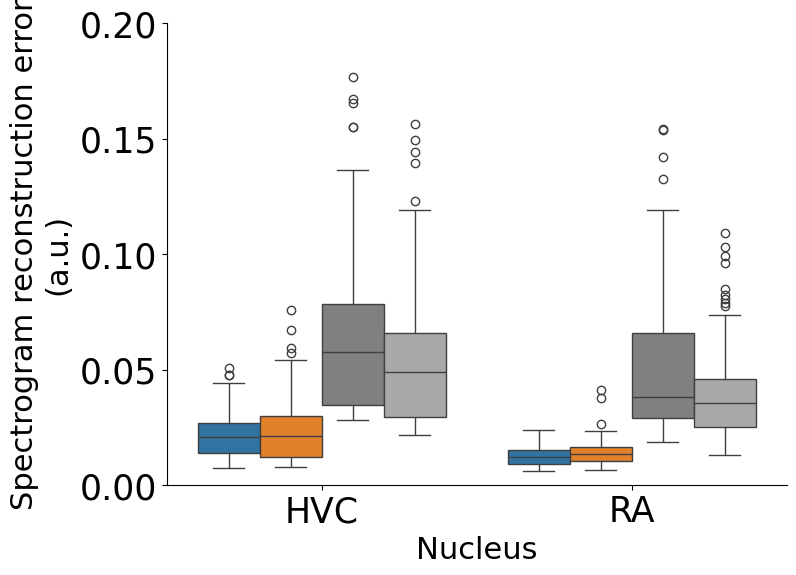

In [116]:
tikcfontsize, fontsize = 25, 22

# Create separate rows for each value in the 'error' list
error_type = 'Spectrogram reconstruction error'
df_expanded = decoding_accuracy_df3.explode(error_type)
df_expanded[error_type] = pd.to_numeric(df_expanded[error_type])

# Define the order of the nucleus explicitly
nucleus_order = ['HVC', 'RA']  # Adjust this list based on the actual names in your dataset
hue_order = ['spiketrains', 'latent-trajectories', 'spiketrains_shuffle-control', 'latent-trajectories_shuffle-control']

# Custom color palette
colors = ['#1f77b4', '#ff7f0e', '#808080', '#A9A9A9']  # Custom colors for each model type
palette = dict(zip(hue_order, colors))

# Create a box and whisker plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='nucleus', y=error_type, hue='model', data=df_expanded, notch=False, palette=palette, order=nucleus_order, hue_order=hue_order)


# Title and labels
plt.xlabel('Nucleus', fontsize=fontsize)
plt.ylabel(error_type+'\n(a.u.)', fontsize=fontsize)
ax.set_ylim([0, 0.2])
# ax.set_xlim([-0.5, len(significance) - 0.5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=tikcfontsize)  # Adjust 'labelsize' as needed
# # Legend
# plt.legend(fontsize='16', loc=(-0.15, 1.1)) 
# ax.get_legend().set_frame_on(False)
ax.get_legend().remove()

# Format xticklabels to show only 2 decimal points
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x:.2f}'))

plt.show()


In [112]:
# Run the t-tests
test_results = perform_t_tests(decoding_accuracy_df3)

pd.set_option('display.max_colwidth', None)
display(test_results)

Comparison  \
0                  HVC latent-trajectories vs. HVC latent-trajectories_shuffle-control   
1                                          HVC latent-trajectories vs. HVC spiketrains   
2                          HVC latent-trajectories vs. HVC spiketrains_shuffle-control   
3                                   HVC latent-trajectories vs. RA latent-trajectories   
4                   HVC latent-trajectories vs. RA latent-trajectories_shuffle-control   
5                                           HVC latent-trajectories vs. RA spiketrains   
6                           HVC latent-trajectories vs. RA spiketrains_shuffle-control   
7                          HVC latent-trajectories_shuffle-control vs. HVC spiketrains   
8          HVC latent-trajectories_shuffle-control vs. HVC spiketrains_shuffle-control   
9                   HVC latent-trajectories_shuffle-control vs. RA latent-trajectories   
10  HVC latent-trajectories_shuffle-control vs. RA latent-trajectories_shuffle-control   
11                          HVC latent-trajectories_shuffle-control vs. RA spiketrains   
12          HVC latent-trajectories_shuffle-control vs. RA spiketrains_shuffle-control   
13                                 HVC spiketrains vs. HVC spiketrains_shuffle-control   
14                                          HVC spiketrains vs. RA latent-trajectories   
15                          HVC spiketrains vs. RA latent-trajectories_shuffle-control   
16                                                  HVC spiketrains vs. RA spiketrains   
17                                  HVC spiketrains vs. RA spiketrains_shuffle-control   
18                          HVC spiketrains_shuffle-control vs. RA latent-trajectories   
19          HVC spiketrains_shuffle-control vs. RA latent-trajectories_shuffle-control   
20                                  HVC spiketrains_shuffle-control vs. RA spiketrains   
21                  HVC spiketrains_shuffle-control vs. RA spiketrains_shuffle-control   
22                   RA latent-trajectories vs. RA latent-trajectories_shuffle-control   
23                                           RA latent-trajectories vs. RA spiketrains   
24                           RA latent-trajectories vs. RA spiketrains_shuffle-control   
25                           RA latent-trajectories_shuffle-control vs. RA spiketrains   
26           RA latent-trajectories_shuffle-control vs. RA spiketrains_shuffle-control   
27                                   RA spiketrains vs. RA spiketrains_shuffle-control   

    t-statistic       p-value  
0    -16.834372  6.767199e-51  
1      1.352092  1.769450e-01  
2    -19.550014  6.209470e-64  
3     11.184950  4.003625e-26  
4    -11.861978  7.845734e-29  
5     13.283899  8.584140e-35  
6    -14.926042  4.631005e-42  
7     18.226172  1.581414e-57  
8     -4.227296  2.803045e-05  
9     23.844713  5.498590e-85  
10     7.483229  3.201166e-13  
11    24.875898  4.895840e-90  
12     0.536149  5.920892e-01  
13   -20.725513  1.130007e-69  
14    11.846383  9.078580e-29  
15   -13.800173  4.881473e-37  
16    14.522359  3.056652e-40  
17   -16.102227  1.824154e-47  
18    25.396840  1.399014e-92  
19    11.363806  7.870850e-27  
20    26.251538  9.679872e-97  
21     4.551835  6.656288e-06  
22   -22.249066  3.772163e-77  
23     4.045752  6.023688e-05  
24   -21.088337  1.884145e-71  
25    23.830293  6.471232e-85  
26    -6.385702  3.843429e-10  
27   -22.016594  5.232070e-76

In [113]:
warnings.filterwarnings("ignore")

bird = 'z_r12r13_21'
models_dict = {
    'spiketrains': {
        'HVC': '030450',
        'RA': '031754'
    },
    
    'latent-trajectories': {
        'HVC': '031418',
        'RA': '031507'
    }
}

# Dirs
models_checkpoints_dir = '/home/jovyan/pablo_tostado/bird_song/enSongDec/ensongdec/models_checkpoints/'
dataset_dir = '/home/jovyan/pablo_tostado/bird_song/enSongDec/data/'

column_names = ['model_name', 'nucleus', 'model', 'Spectrogram reconstruction error']
decoding_accuracy_df4 = pd.DataFrame(columns=column_names)


# Processing each model type and nucleus
for col, model_type in enumerate(models_dict):
    for row, nucleus in enumerate(models_dict[model_type]):
        print(model_type, nucleus)

        # Load model
        model_timestamp = models_dict[model_type][nucleus]
        model_extension = '.pt'  
        model_files = [file for file in os.listdir(models_checkpoints_dir) if file.endswith(model_extension)]
        model_filename = next((file for file in model_files if model_timestamp in file), None)

        for control in ['normal', 'control']:
            print(f'Loading model {model_filename} in {control} mode')
                            
            if control == 'control': 
                ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scales = load_model_statedict(models_checkpoints_dir, dataset_dir, model_filename, shuffle_inputs=True)
            else:
                ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scales = load_model_statedict(models_checkpoints_dir, dataset_dir, model_filename, shuffle_inputs=False)
    
            # Reconstruct spectrogram
            scale = torch.mean(scales)
            original_audio, decoded_audio = generate_original_and_reconstructed_audio(ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scale)
    
            # Calculate spectrogram reconstruction error
            s1 = su.normalize_signal(au.pretty_spectrogram(original_audio))
            s2 = su.normalize_signal(au.pretty_spectrogram(decoded_audio))
            spec_reconstruction_error = mean_squared_error(s1, s2, multioutput='raw_values')
            
            model = model_type+'_shuffle-control' if control == 'control' else model_type
            decoding_accuracy_df4.loc[len(decoding_accuracy_df4)] = [model_filename, nucleus, model, spec_reconstruction_error]

spiketrains HVC
Loading model z_r12r13_21_RAW_hvc_all_FFNN_20240409_030450.pt in normal mode
Loading z_r12r13_21_RAW_hvc_all_FFNN_20240409_030450_metadata.json
Loaded model: train_idxs:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]  - test_ixs:  [37, 38, 39, 40, 41, 42, 43, 44, 45, 46]  - model_layers:  [150, 64, 64, 128]
Length of neural trials: 899.9666666666667 ms, length of audio trials: 899.96 ms. 
Using 3 bins of neural data history.
Dataset and Dataloader created. Samples: 4810
Dataset and Dataloader created. Samples: 1320
Train samples:  4810 Test samples:  1320
Loading model z_r12r13_21_RAW_hvc_all_FFNN_20240409_030450.pt in control mode
Loading z_r12r13_21_RAW_hvc_all_FFNN_20240409_030450_metadata.json
Loaded model: train_idxs:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]  - test_ixs:  [37,

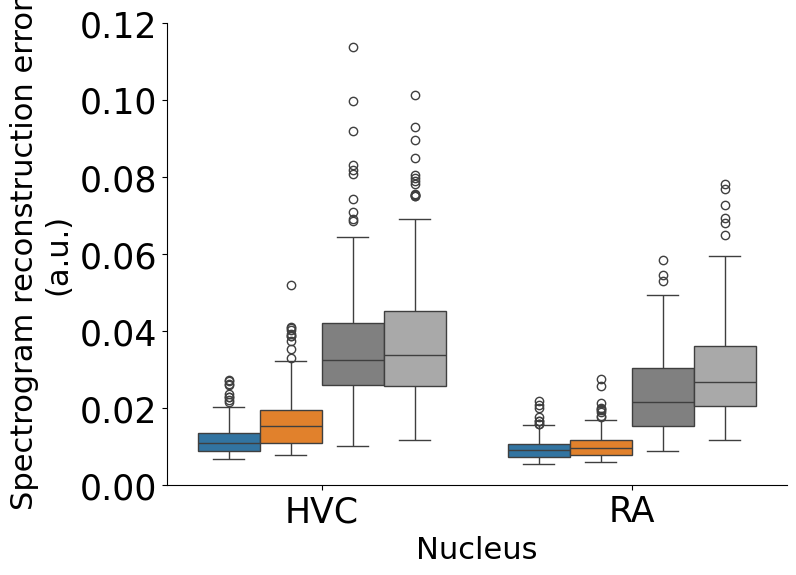

In [114]:
tikcfontsize, fontsize = 25, 22

# Create separate rows for each value in the 'error' list
error_type = 'Spectrogram reconstruction error'
df_expanded = decoding_accuracy_df4.explode(error_type)
df_expanded[error_type] = pd.to_numeric(df_expanded[error_type])

# Define the order of the nucleus explicitly
nucleus_order = ['HVC', 'RA']  # Adjust this list based on the actual names in your dataset
hue_order = ['spiketrains', 'latent-trajectories', 'spiketrains_shuffle-control', 'latent-trajectories_shuffle-control']

# Custom color palette
colors = ['#1f77b4', '#ff7f0e', '#808080', '#A9A9A9']  # Custom colors for each model type
palette = dict(zip(hue_order, colors))

# Create a box and whisker plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='nucleus', y=error_type, hue='model', data=df_expanded, notch=False, palette=palette, order=nucleus_order, hue_order=hue_order)


# Title and labels
plt.xlabel('Nucleus', fontsize=fontsize)
plt.ylabel(error_type+'\n(a.u.)', fontsize=fontsize)
ax.set_ylim([0, 0.12])
# ax.set_xlim([-0.5, len(significance) - 0.5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=tikcfontsize)  # Adjust 'labelsize' as needed
# plt.legend(fontsize='16', loc=(0,1.1)) 
# ax.get_legend().set_frame_on(False)
ax.get_legend().remove()

# Format xticklabels to show only 2 decimal points
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x:.2f}'))

plt.show()


In [115]:
# Run the t-tests
test_results = perform_t_tests(decoding_accuracy_df4)

pd.set_option('display.max_colwidth', None)
display(test_results)

Comparison  \
0                  HVC latent-trajectories vs. HVC latent-trajectories_shuffle-control   
1                                          HVC latent-trajectories vs. HVC spiketrains   
2                          HVC latent-trajectories vs. HVC spiketrains_shuffle-control   
3                                   HVC latent-trajectories vs. RA latent-trajectories   
4                   HVC latent-trajectories vs. RA latent-trajectories_shuffle-control   
5                                           HVC latent-trajectories vs. RA spiketrains   
6                           HVC latent-trajectories vs. RA spiketrains_shuffle-control   
7                          HVC latent-trajectories_shuffle-control vs. HVC spiketrains   
8          HVC latent-trajectories_shuffle-control vs. HVC spiketrains_shuffle-control   
9                   HVC latent-trajectories_shuffle-control vs. RA latent-trajectories   
10  HVC latent-trajectories_shuffle-control vs. RA latent-trajectories_shuffle-control   
11                          HVC latent-trajectories_shuffle-control vs. RA spiketrains   
12          HVC latent-trajectories_shuffle-control vs. RA spiketrains_shuffle-control   
13                                 HVC spiketrains vs. HVC spiketrains_shuffle-control   
14                                          HVC spiketrains vs. RA latent-trajectories   
15                          HVC spiketrains vs. RA latent-trajectories_shuffle-control   
16                                                  HVC spiketrains vs. RA spiketrains   
17                                  HVC spiketrains vs. RA spiketrains_shuffle-control   
18                          HVC spiketrains_shuffle-control vs. RA latent-trajectories   
19          HVC spiketrains_shuffle-control vs. RA latent-trajectories_shuffle-control   
20                                  HVC spiketrains_shuffle-control vs. RA spiketrains   
21                  HVC spiketrains_shuffle-control vs. RA spiketrains_shuffle-control   
22                   RA latent-trajectories vs. RA latent-trajectories_shuffle-control   
23                                           RA latent-trajectories vs. RA spiketrains   
24                           RA latent-trajectories vs. RA spiketrains_shuffle-control   
25                           RA latent-trajectories_shuffle-control vs. RA spiketrains   
26           RA latent-trajectories_shuffle-control vs. RA spiketrains_shuffle-control   
27                                   RA spiketrains vs. RA spiketrains_shuffle-control   

    t-statistic        p-value  
0    -18.797068   2.792923e-60  
1      9.349206   2.765866e-19  
2    -18.637598   1.646885e-59  
3     12.881069   4.540917e-33  
4    -14.322660   2.387375e-39  
5     14.858412   9.372864e-42  
6     -9.268906   5.277668e-19  
7     24.913564   3.204023e-90  
8      0.811895   4.172308e-01  
9     26.733997   4.431101e-99  
10     5.857866   8.413448e-09  
11    27.706792  8.952555e-104  
12    11.775568   1.758938e-28  
13   -25.153689   2.150418e-91  
14     5.038878   6.512327e-07  
15   -21.734146   1.276216e-74  
16     8.093379   4.283162e-15  
17   -18.482566   9.218521e-59  
18    27.093292  8.109083e-101  
19     5.159709   3.548168e-07  
20    28.133458  8.002979e-106  
21    11.278684   1.710201e-26  
22   -24.010075   8.497458e-86  
23     3.079965   2.181905e-03  
24   -21.495036   1.904779e-73  
25    25.239930   8.155889e-92  
26     6.237602   9.338121e-10  
27   -23.158529   1.283711e-81

# Bottom panel: Stability Analysis 

# Bird 1 - z_w12m7_20

spiketrains_halved_alinged HVC
Loading model:  RAW_z_w12m7_20_20240509_050826_hvc_all_latent_stability_dataset_FFNN_20240509_052938.pt
Loading RAW_z_w12m7_20_20240509_050826_hvc_all_latent_stability_dataset_FFNN_20240509_052938_metadata.json
Loaded model: train_idxs:  [0, 1, 2, 3, 4, 5, 6, 7]  - test_ixs:  [8, 9]  - model_layers:  [114, 64, 64, 128]
Length of neural trials: 700.0 ms, length of audio trials: 700.0 ms. 
Fitting CCA model to align neural spaces.
n_dims:  57
(150000, 57) (150000, 57)
fitting CCA model
CCA fitted!
Length of neural trials: 700.0 ms, length of audio trials: 700.0 ms. 
Using 2 bins of neural data history.
Dataset and Dataloader created. Samples: 808
Dataset and Dataloader created. Samples: 206
Train samples:  808 Test samples:  206
(34334,) (34334,)
spiketrains_halved_alinged RA
Loading model:  RAW_z_w12m7_20_20240509_051627_ra_all_latent_stability_dataset_FFNN_20240509_053009.pt
Loading RAW_z_w12m7_20_20240509_051627_ra_all_latent_stability_dataset_FFNN_20240

(Text(0, 0.5, ''), [])

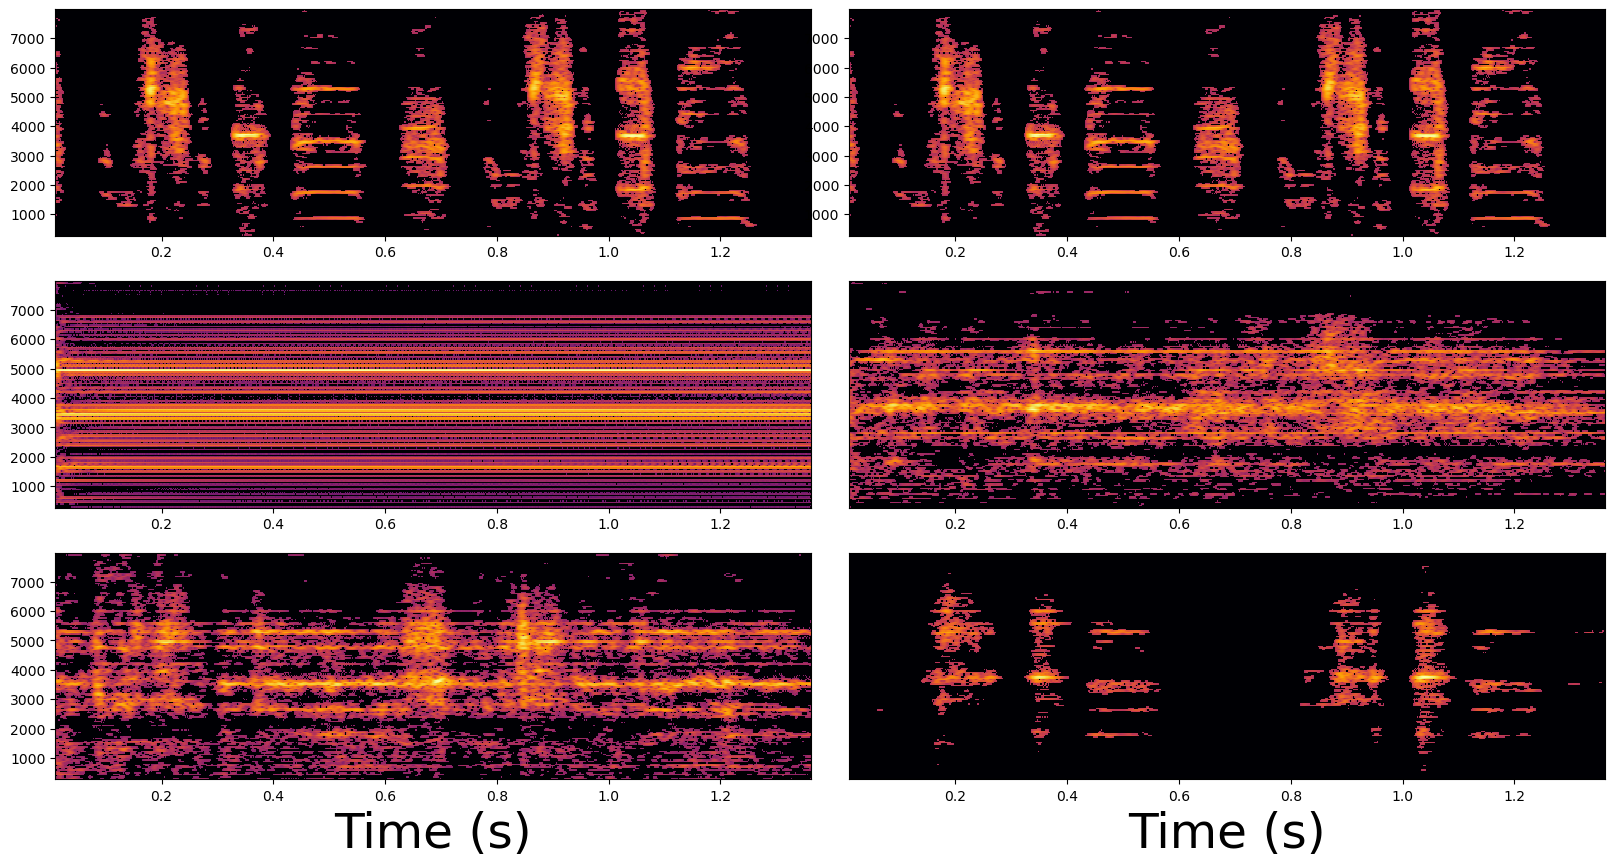

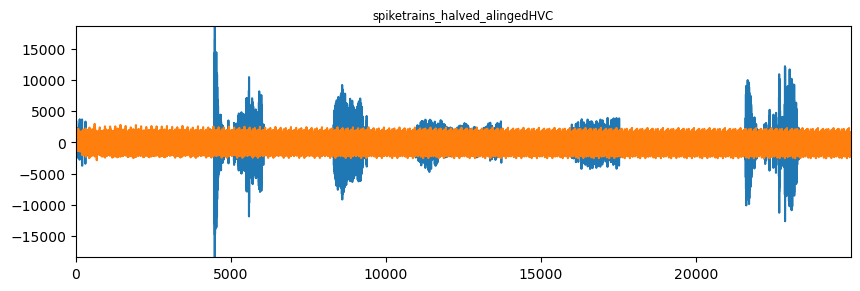

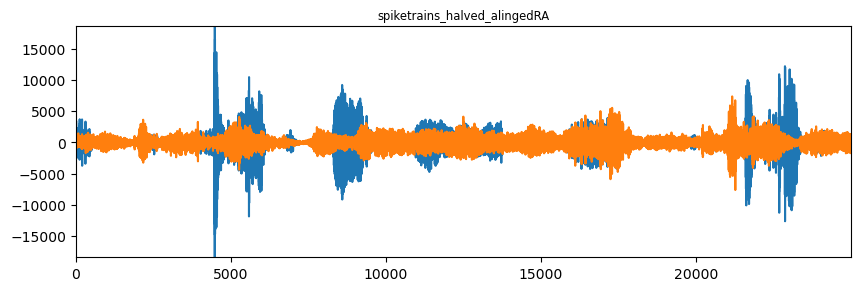

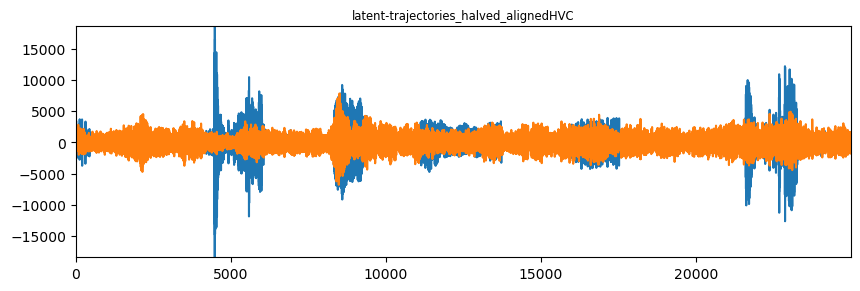

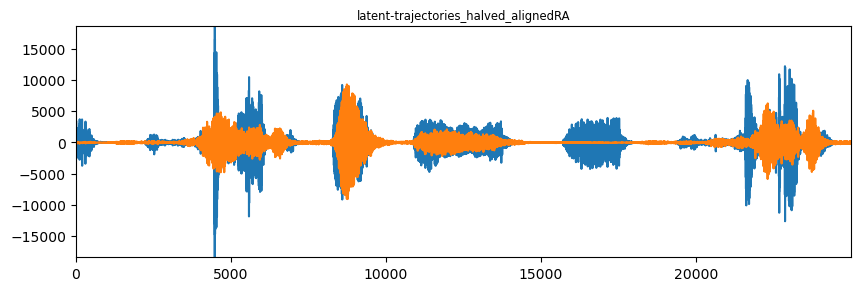

In [92]:
bird = 'z_w12m7_20'
models_dict = {
    'spiketrains_halved_alinged': {
        'HVC': '20240509_052938',
        'RA': '20240509_053009'
    },
    
    'latent-trajectories_halved_aligned': {
        'HVC': '20240509_053018',
        'RA': '20240509_053026'
    }
}


# Dirs
models_checkpoints_dir = '/home/jovyan/pablo_tostado/bird_song/enSongDec/ensongdec/models_checkpoints/'
dataset_dir = '/home/jovyan/pablo_tostado/bird_song/enSongDec/data/'

column_names = ['model_name', 'nucleus', 'model', 'Spectrogram reconstruction error']
decoding_accuracy_df5 = pd.DataFrame(columns=column_names)

# Plotting setup
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))
plt.subplots_adjust(wspace=0.05)

# Processing each model type and nucleus
for col, model_type in enumerate(models_dict):
    for row, nucleus in enumerate(models_dict[model_type]):

        if models_dict[model_type][nucleus]:
            print(model_type, nucleus)
    
            # Load model
            model_timestamp = models_dict[model_type][nucleus]
            model_extension = '.pt'  
            model_files = [file for file in os.listdir(models_checkpoints_dir) if file.endswith(model_extension)]
            model_filename = next((file for file in model_files if model_timestamp in file), None)
    
            print('Loading model: ', model_filename)
            ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scales = load_model_statedict_align_complimentary_space(models_checkpoints_dir, dataset_dir, model_filename)
    
            # Reconstruct spectrogram
            scale = torch.mean(scales)
            original_audio, decoded_audio = generate_original_and_reconstructed_audio(ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scale)
            
            print(original_audio.shape, decoded_audio.shape)
    
            # Calculate spectrogram reconstruction error
            s1 = su.normalize_signal(au.pretty_spectrogram(original_audio))
            s2 = su.normalize_signal(au.pretty_spectrogram(decoded_audio))
            spec_reconstruction_error = mean_squared_error(s1, s2, multioutput='raw_values')
            
            decoding_accuracy_df5.loc[len(decoding_accuracy_df5)] = [model_filename, nucleus, model_type, spec_reconstruction_error]
    
            # Plot original and reconstructed
            plot_s = 1
            plot_samples = int(plot_s*fs_audio)
            
            plt.subplots(nrows=1, figsize=(10, 3))
            plt.title(model_type + nucleus)
            plt.plot(original_audio[:plot_samples])
            plt.plot(decoded_audio[:plot_samples])
            
            xlabel = True if row == 1 else False
            # ylabel = True if col == 0 else False
            # au.plot_spectrogram(original_audio, fs_audio, plot_samples, ax=axes[row+1, col], xlabel=xlabel)
            au.plot_spectrogram(decoded_audio, fs_audio, ax=axes[row+1, col], xlabel=xlabel)

# Top row: repeat the plot of the original spectrograms in both columns
au.plot_spectrogram(original_audio, fs_audio, ax=axes[0, 0], xlabel=False)
au.plot_spectrogram(original_audio, fs_audio, ax=axes[0, 1], xlabel=False)
axes[1,1].set_ylabel(''), axes[1,1].set_yticks([])
axes[2,1].set_ylabel(''), axes[2,1].set_yticks([])

In [93]:
# Run the t-tests
test_results = perform_t_tests(decoding_accuracy_df5)

pd.set_option('display.max_colwidth', None)
display(test_results)

Comparison  \
0         HVC latent-trajectories_halved_aligned vs. HVC spiketrains_halved_alinged   
1  HVC latent-trajectories_halved_aligned vs. RA latent-trajectories_halved_aligned   
2          HVC latent-trajectories_halved_aligned vs. RA spiketrains_halved_alinged   
3          HVC spiketrains_halved_alinged vs. RA latent-trajectories_halved_aligned   
4                  HVC spiketrains_halved_alinged vs. RA spiketrains_halved_alinged   
5           RA latent-trajectories_halved_aligned vs. RA spiketrains_halved_alinged   

   t-statistic       p-value  
0   -11.319576  1.178489e-26  
1     9.589852  3.899549e-20  
2    -0.314192  7.535034e-01  
3    19.343161  6.292447e-63  
4    11.418602  4.767427e-27  
5   -10.918213  4.401566e-25

In [98]:
# plot_test_results

In [95]:
plot_test_results = test_results.loc[test_results['Comparison'].isin([
    'HVC latent-trajectories_halved_aligned vs. HVC spiketrains_halved_alinged', 
    'RA latent-trajectories_halved_aligned vs. RA spiketrains_halved_alinged'
])]['p-value'].tolist()


plot_test_results

[1.1784893490513545e-26, 4.40156648131728e-25]

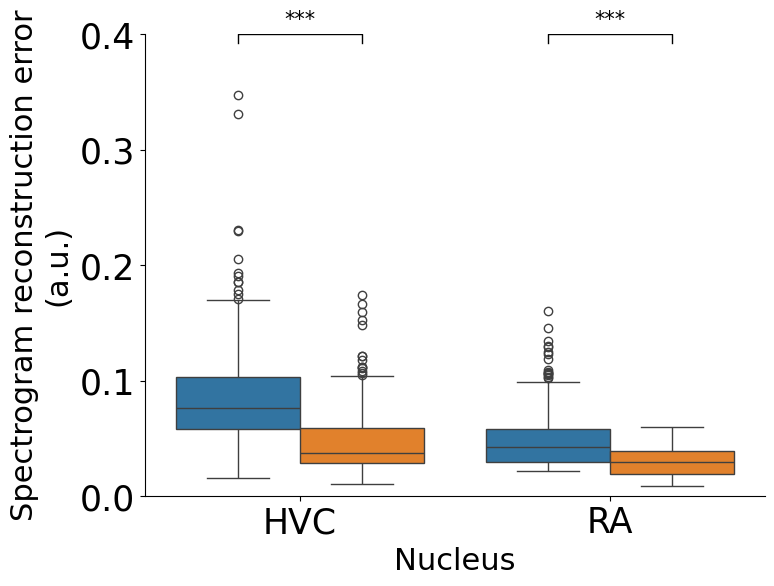

In [96]:
asterix_size, tikcfontsize, fontsize = 15, 25, 22

# Create separate rows for each value in the 'error' list
error_type = 'Spectrogram reconstruction error'
df_expanded = decoding_accuracy_df5.explode(error_type)
df_expanded[error_type] = pd.to_numeric(df_expanded[error_type])

# Create a box and whisker plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='nucleus', y=error_type, hue='model', data=df_expanded, notch=False)

plt.xlabel('Nucleus', fontsize=fontsize)
plt.ylabel(error_type+'\n(a.u.)', fontsize=fontsize)

# Plot statistical significance bars & p-value
bottom, top = ax.get_ylim()
top = 0.4
y_range = top - bottom
pval_bar_separation = 0.5
sample_size_separation = 0.5
for ii in range(len(plot_test_results)):
    # Plot the bar
    bar_height = top
    bar_tips = bar_height - (y_range * 0.02)
    
    plt.plot(
            [ii-0.2, ii-0.2, ii+0.2, ii+0.2],
            [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
    )
    # Significance level
    p = plot_test_results[ii]
    sig_symbol = ''
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    text_height = bar_height + (y_range * 0.01)
    plt.text((ii-0.2 + ii+0.2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k', fontsize=asterix_size)

# Remove top and right spines
ax.set_ylim([0, 0.4])
ax.set_xlim([-0.5, 2 - 0.5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=tikcfontsize)  # Adjust 'labelsize' as needed
# plt.legend(fontsize='16', loc=(0,1.1)) 
ax.get_legend().remove()

plt.show()

# Bird 2 - z_r12r13_21

spiketrains_halved_alinged HVC
Loading model:  RAW_z_r12r13_21_20240503_024021_hvc_all_latent_stability_dataset_FFNN_20240509_051853.pt
Loading RAW_z_r12r13_21_20240503_024021_hvc_all_latent_stability_dataset_FFNN_20240509_051853_metadata.json
Loaded model: train_idxs:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]  - test_ixs:  [37, 38, 39, 40, 41, 42, 43, 44, 45, 46]  - model_layers:  [75, 64, 64, 128]
Length of neural trials: 899.9666666666667 ms, length of audio trials: 899.96 ms. 
Fitting CCA model to align neural spaces.
n_dims:  25
(986953, 25) (986953, 25)
fitting CCA model
CCA fitted!
Length of neural trials: 899.9666666666667 ms, length of audio trials: 899.96 ms. 
Using 3 bins of neural data history.
Dataset and Dataloader created. Samples: 4810
Dataset and Dataloader created. Samples: 1320
Train samples:  4810 Test samples:  1320
(220000,) (220000,)
spiketrains_halved_alinged RA
Loa

(Text(0, 0.5, ''), [])

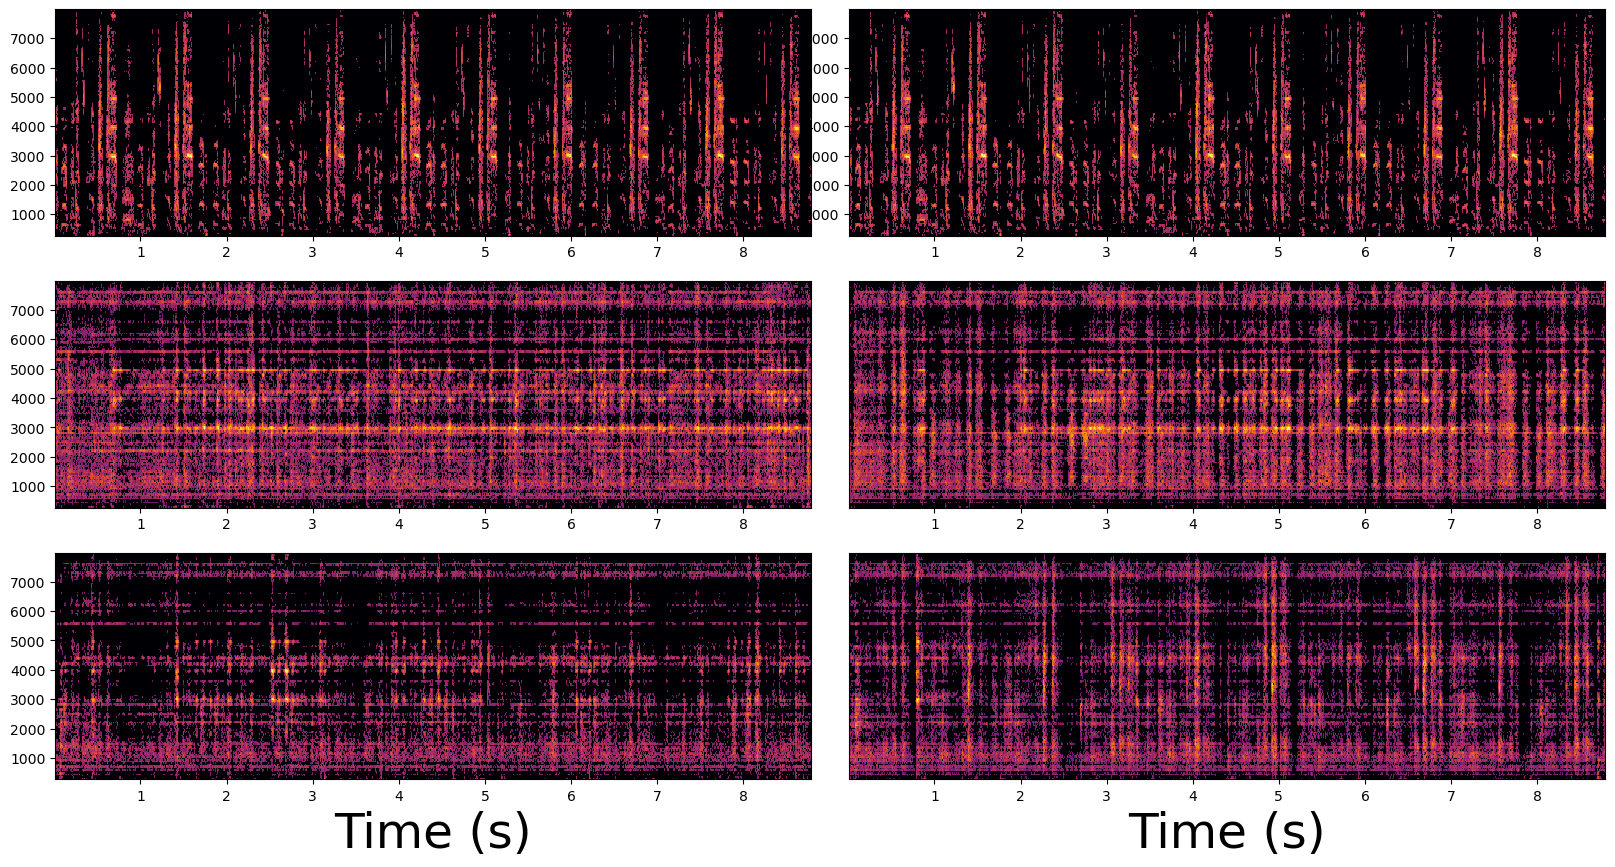

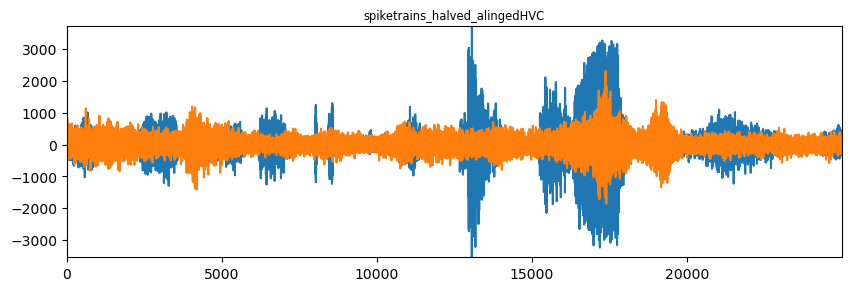

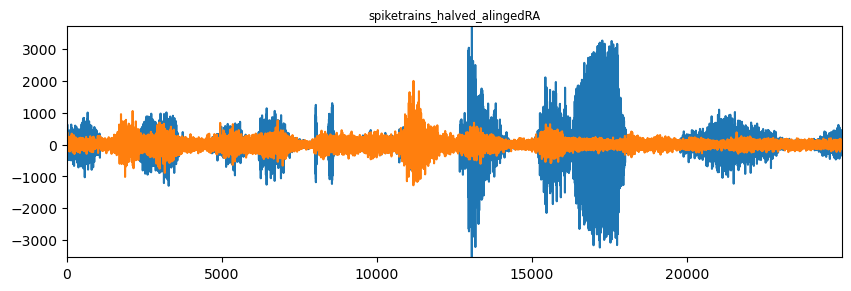

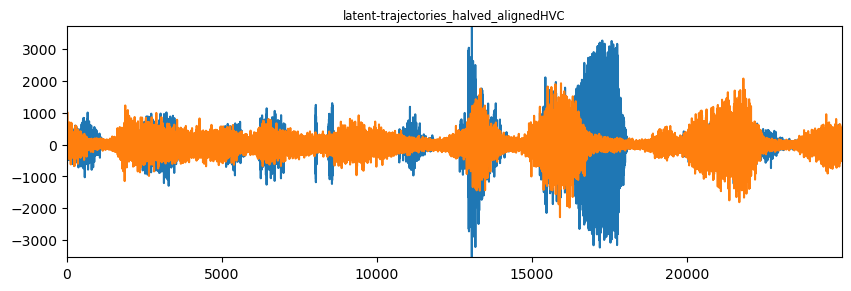

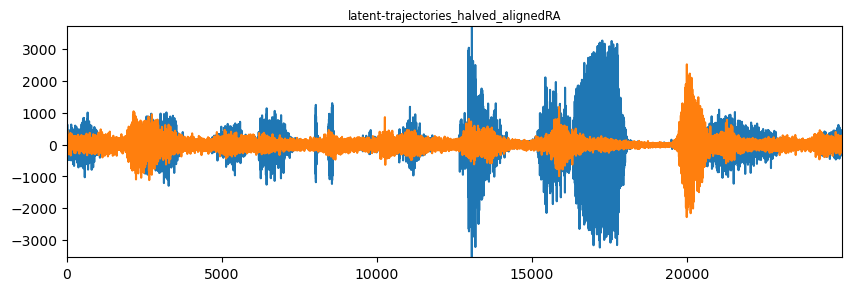

In [76]:
warnings.filterwarnings("ignore")

bird = 'z_r12r13_21'
models_dict = {
    'spiketrains_halved_alinged': {
        'HVC': '20240509_051853',
        'RA': '20240509_051849'
    },
    
    'latent-trajectories_halved_aligned': {
        'HVC': '20240508_230047',
        'RA': '20240503_000101'
    }
}


# Dirs
models_checkpoints_dir = '/home/jovyan/pablo_tostado/bird_song/enSongDec/ensongdec/models_checkpoints/'
dataset_dir = '/home/jovyan/pablo_tostado/bird_song/enSongDec/data/'

column_names = ['model_name', 'nucleus', 'model', 'Spectrogram reconstruction error']
decoding_accuracy_df6 = pd.DataFrame(columns=column_names)

# Plotting setup
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))
plt.subplots_adjust(wspace=0.05)

# Processing each model type and nucleus
for col, model_type in enumerate(models_dict):
    for row, nucleus in enumerate(models_dict[model_type]):

        if models_dict[model_type][nucleus]:
            print(model_type, nucleus)
    
            # Load model
            model_timestamp = models_dict[model_type][nucleus]
            model_extension = '.pt'  
            model_files = [file for file in os.listdir(models_checkpoints_dir) if file.endswith(model_extension)]
            model_filename = next((file for file in model_files if model_timestamp in file), None)
    
            print('Loading model: ', model_filename)
            ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scales = load_model_statedict_align_complimentary_space(models_checkpoints_dir, dataset_dir, model_filename)
    
            # Reconstruct spectrogram
            scale = torch.mean(scales)
            original_audio, decoded_audio = generate_original_and_reconstructed_audio(ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scale)
            
            print(original_audio.shape, decoded_audio.shape)
    
            # Calculate spectrogram reconstruction error
            s1 = su.normalize_signal(au.pretty_spectrogram(original_audio))
            s2 = su.normalize_signal(au.pretty_spectrogram(decoded_audio))
            spec_reconstruction_error = mean_squared_error(s1, s2, multioutput='raw_values')
            
            decoding_accuracy_df6.loc[len(decoding_accuracy_df6)] = [model_filename, nucleus, model_type, spec_reconstruction_error]
    
            # Plot original and reconstructed
            plot_s = 1
            plot_samples = int(plot_s*fs_audio)
            
            plt.subplots(nrows=1, figsize=(10, 3))
            plt.title(model_type + nucleus)
            plt.plot(original_audio[:plot_samples])
            plt.plot(decoded_audio[:plot_samples])
            
            xlabel = True if row == 1 else False
            # ylabel = True if col == 0 else False
            # au.plot_spectrogram(original_audio, fs_audio, plot_samples, ax=axes[row+1, col], xlabel=xlabel)
            au.plot_spectrogram(decoded_audio, fs_audio, ax=axes[row+1, col], xlabel=xlabel)

# Top row: repeat the plot of the original spectrograms in both columns
au.plot_spectrogram(original_audio, fs_audio, ax=axes[0, 0], xlabel=False)
au.plot_spectrogram(original_audio, fs_audio, ax=axes[0, 1], xlabel=False)
axes[1,1].set_ylabel(''), axes[1,1].set_yticks([])
axes[2,1].set_ylabel(''), axes[2,1].set_yticks([])

In [77]:
len(decoding_accuracy_df6)

4

In [78]:
# Run the t-tests
test_results = perform_t_tests(decoding_accuracy_df6)

pd.set_option('display.max_colwidth', None)
display(test_results)

Comparison  \
0         HVC latent-trajectories_halved_aligned vs. HVC spiketrains_halved_alinged   
1  HVC latent-trajectories_halved_aligned vs. RA latent-trajectories_halved_aligned   
2          HVC latent-trajectories_halved_aligned vs. RA spiketrains_halved_alinged   
3          HVC spiketrains_halved_alinged vs. RA latent-trajectories_halved_aligned   
4                  HVC spiketrains_halved_alinged vs. RA spiketrains_halved_alinged   
5           RA latent-trajectories_halved_aligned vs. RA spiketrains_halved_alinged   

   t-statistic       p-value  
0    -3.535625  4.438731e-04  
1     6.334331  5.239388e-10  
2     8.467396  2.688103e-16  
3     9.269102  5.269386e-19  
4    11.128405  6.674475e-26  
5     2.172059  3.031120e-02

In [79]:
plot_test_results = test_results.loc[test_results['Comparison'].isin([
    'HVC latent-trajectories_halved_aligned vs. HVC spiketrains_halved_alinged', 
    'RA latent-trajectories_halved_aligned vs. RA spiketrains_halved_alinged'
])]['p-value'].tolist()

plot_test_results

[0.00044387314517349915, 0.030311202647607293]

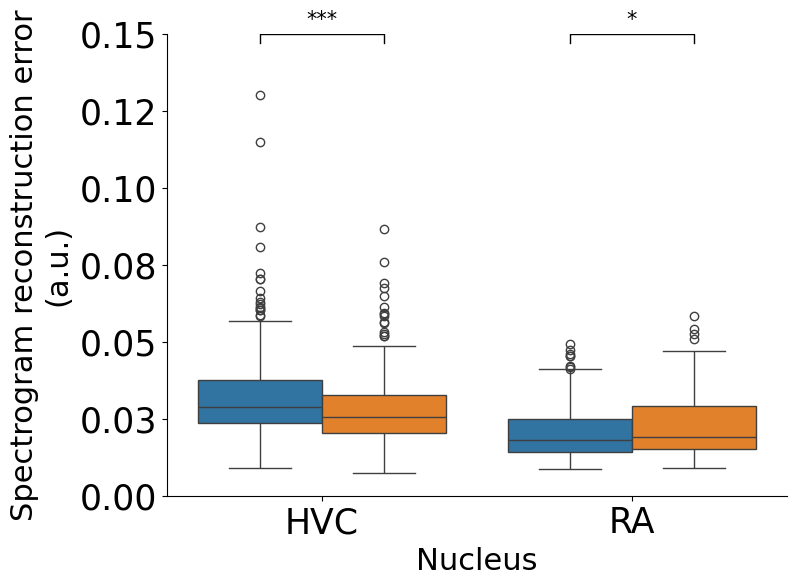

In [89]:
asterix_size, tikcfontsize, fontsize = 15, 25, 22

# Create separate rows for each value in the 'error' list
error_type = 'Spectrogram reconstruction error'
df_expanded = decoding_accuracy_df6.explode(error_type)
df_expanded[error_type] = pd.to_numeric(df_expanded[error_type])

# Create a box and whisker plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='nucleus', y=error_type, hue='model', data=df_expanded, notch=False)

plt.xlabel('Nucleus', fontsize=fontsize)
plt.ylabel(error_type+'\n(a.u.)', fontsize=fontsize)

# Plot statistical significance bars & p-value
bottom, top = ax.get_ylim()
top = 0.15
y_range = top - bottom
pval_bar_separation = 0.5
sample_size_separation = 0.5
for ii in range(len(plot_test_results)):
    # Plot the bar
    bar_height = top
    bar_tips = bar_height - (y_range * 0.02)
    
    plt.plot(
            [ii-0.2, ii-0.2, ii+0.2, ii+0.2],
            [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
    )
    # Significance level
    p = plot_test_results[ii]
    sig_symbol = ''
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    text_height = bar_height + (y_range * 0.01)
    plt.text((ii-0.2 + ii+0.2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k', fontsize=asterix_size)

# Remove top and right spines
ax.set_ylim([0, 0.15])
ax.set_xlim([-0.5, 2 - 0.5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=tikcfontsize)  # Adjust 'labelsize' as needed
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x:.2f}'))
# plt.legend(fontsize='16', loc=(0,1.1)) 
ax.get_legend().remove()

plt.show()

In [ ]:
# Create separate rows for each value in the 'error' list
error_type = 'Spectrogram reconstruction error'
df_expanded = decoding_accuracy_df6.explode(error_type)
df_expanded[error_type] = pd.to_numeric(df_expanded[error_type])

# Create a box and whisker plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='nucleus', y=error_type, hue='model', data=df_expanded, notch=False)

plt.xlabel('Nucleus', fontsize=16, fontweight='bold')
plt.ylabel(error_type+' (a.u.)', fontsize=16, fontweight='bold')

# Remove top and right spines
ax.set_ylim([0, 0.14])
# ax.set_xlim([-0.5, len(significance) - 0.5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=20)  # Adjust 'labelsize' as needed
plt.legend(fontsize='16', loc=(0,1.1)) 
ax.get_legend().remove()

plt.show()